In [148]:
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns 
import numpy as np
import random
from datetime import timedelta

In [149]:
df=pd.read_csv("Assessment exercise dataset - orders.csv")

In [150]:
df['order_date'] = pd.to_datetime(df['order_timestamp'],infer_datetime_format=True)

In [151]:
df.drop("order_timestamp", axis=1, inplace=True)

In [152]:
df=df.sort_values(by='order_date',ascending=True)

In [153]:
df['month'] = pd.to_datetime(df['order_date']).dt.month

In [154]:
df['day']=df['order_date'].dt.day_name()

In [155]:
df['hour'] = pd.to_datetime(df['order_date']).dt.hour

In [156]:
df2 = df.groupby(['user_id','city'])['order_id'].agg('count').reset_index()
display(df2)

,user_id,city,order_id
0,44118921,Λαμία,1
1,108938802,Λέρος,3
2,110361993,Ρόδος,11
3,138437670,Άρτα,1
4,144777339,Αίγιο,14
...,...,...,...
124226,685557444369,Ξάνθη,1
124227,685561325799,Λάρισα,1
124228,685561843323,Βόλος,1
124229,685566242277,Δράμα,1


In [157]:
df2.rename(columns = {'order_id':'Num_of_orders'}, inplace = True)

In [158]:
df2=pd.merge(df2,df, left_on='user_id', right_on='user_id')

In [159]:
df2.drop("city_y", axis=1, inplace=True)

In [160]:
df2.rename(columns = {'city_x':'city'}, inplace = True)

In [161]:
df2_break=df2[df2['cuisine']=='Breakfast']

In [162]:
df2_break.head()

,user_id,city,Num_of_orders,order_id,cuisine,paid_cash,amount,order_date,month,day,hour
7,110361993,Ρόδος,11,7249621603152,Breakfast,False,4.3,2022-01-08 11:17:38+00:00,1,Saturday,11
16,144777339,Αίγιο,14,7214818797164,Breakfast,False,4.8,2022-01-03 09:45:07+00:00,1,Monday,9
17,144777339,Αίγιο,14,7222040969548,Breakfast,False,3.3,2022-01-04 11:13:56+00:00,1,Tuesday,11
18,144777339,Αίγιο,14,7228946244036,Breakfast,False,3.2,2022-01-05 12:09:20+00:00,1,Wednesday,12
19,144777339,Αίγιο,14,7236022202912,Breakfast,True,4.6,2022-01-06 12:53:50+00:00,1,Thursday,12


In [163]:
from datetime import timedelta
snapshot_date = df2_break['order_date'].max() + timedelta(days=1)
print(snapshot_date)

2022-02-01 23:59:25+00:00


In [164]:
#groupby to get RFM data from each client only for breakfast
#amount gives us the sum of monetary value
#Num_of_orders counts orders (frequency)
#order date subtracks the last order from the snapshot date we explained earlier. (recency)

user_data= df2_break.groupby(['user_id']).agg({
        'order_date': lambda x: (snapshot_date - x.max()).days,
        'Num_of_orders': 'count',
        'amount': 'sum'})

In [165]:
user_data

,order_date,Num_of_orders,amount
user_id,,,
110361993,24,1,4.3
144777339,1,14,60.8
145424244,10,1,11.9
153963390,4,1,9.0
155515962,24,1,5.5
...,...,...,...
685517465640,1,1,2.0
685519276974,1,1,5.4
685526134167,1,1,6.1


In [166]:
#Rename columns for RFM
user_data.rename(columns={'order_date': 'Recency',
                         'Num_of_orders': 'Frequency',
                         'amount': 'MonetaryValue'}, inplace=True)

In [167]:
user_data.head()

,Recency,Frequency,MonetaryValue
user_id,,,
110361993,24,1,4.3
144777339,1,14,60.8
145424244,10,1,11.9
153963390,4,1,9.0
155515962,24,1,5.5


In [168]:
quartiles = user_data.quantile(q=[0.25,0.50,0.75])
print(quartiles, type(quartiles))

      Recency  Frequency  MonetaryValue
0.25      3.0        1.0            5.8
0.50      9.0        2.0           11.1
0.75     20.0        4.0           23.4 <class 'pandas.core.frame.DataFrame'>


In [169]:
quartiles=quartiles.to_dict()
quartiles

{'Recency': {0.25: 3.0, 0.5: 9.0, 0.75: 20.0},
 'Frequency': {0.25: 1.0, 0.5: 2.0, 0.75: 4.0},
 'MonetaryValue': {0.25: 5.8, 0.5: 11.1, 0.75: 23.4}}

In [170]:
def RClass(x,p,d):
    if x <= d[p][0.25]:
        return 1
    elif x <= d[p][0.50]:
        return 2
    elif x <= d[p][0.75]: 
        return 3
    else:
        return 4

def FMClass(x,p,d):
    if x <= d[p][0.25]:
        return 4
    elif x <= d[p][0.50]:
        return 3
    elif x <= d[p][0.75]: 
        return 2
    else:
        return 1  

In [171]:
rfmSeg = user_data
rfmSeg['R_Quartile'] = rfmSeg['Recency'].apply(RClass, args=('Recency',quartiles,))
rfmSeg['F_Quartile'] = rfmSeg['Frequency'].apply(FMClass, args=('Frequency',quartiles,))
rfmSeg['M_Quartile'] = rfmSeg['MonetaryValue'].apply(FMClass, args=('MonetaryValue',quartiles,))

In [172]:
rfmSeg['RFMClass'] = rfmSeg.R_Quartile.map(str) \
                            + rfmSeg.F_Quartile.map(str) \
                            + rfmSeg.M_Quartile.map(str)

In [173]:
rfmSeg.head()

,Recency,Frequency,MonetaryValue,R_Quartile,F_Quartile,M_Quartile,RFMClass
user_id,,,,,,,
110361993,24,1,4.3,4,4,4,444
144777339,1,14,60.8,1,1,1,111
145424244,10,1,11.9,3,4,2,342
153963390,4,1,9.0,2,4,3,243
155515962,24,1,5.5,4,4,4,444


In [174]:
rfmSeg.sort_values(by=['RFMClass', 'MonetaryValue'], ascending=[True, False])


,Recency,Frequency,MonetaryValue,R_Quartile,F_Quartile,M_Quartile,RFMClass
user_id,,,,,,,
154559060124,1,114,686.0,1,1,1,111
104460666828,1,99,564.5,1,1,1,111
119884693362,1,85,543.1,1,1,1,111
488284282143,1,62,507.9,1,1,1,111
96191797737,1,54,458.5,1,1,1,111
...,...,...,...,...,...,...,...
99007645821,25,1,0.5,4,4,4,444
296635311987,30,1,0.5,4,4,4,444
469605159030,22,1,0.5,4,4,4,444


In [175]:
rfmSeg.groupby('RFMClass').agg('MonetaryValue').mean()


RFMClass
111    61.267393
112    18.773830
113     9.940588
114     3.000000
121    31.778739
         ...    
434     4.547553
441    30.962234
442    14.516251
443     7.833340
444     4.002625
Name: MonetaryValue, Length: 61, dtype: float64

In [176]:
rfmSeg['Total Score'] = rfmSeg['R_Quartile'] + rfmSeg['F_Quartile'] +rfmSeg['M_Quartile']
print(rfmSeg.head(), rfmSeg.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 55834 entries, 110361993 to 685566242277
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Recency        55834 non-null  int64  
 1   Frequency      55834 non-null  int64  
 2   MonetaryValue  55834 non-null  float64
 3   R_Quartile     55834 non-null  int64  
 4   F_Quartile     55834 non-null  int64  
 5   M_Quartile     55834 non-null  int64  
 6   RFMClass       55834 non-null  object 
 7   Total Score    55834 non-null  int64  
dtypes: float64(1), int64(6), object(1)
memory usage: 3.8+ MB
           Recency  Frequency  MonetaryValue  R_Quartile  F_Quartile  \
user_id                                                                
110361993       24          1            4.3           4           4   
144777339        1         14           60.8           1           1   
145424244       10          1           11.9           3           4   
153963390      

In [177]:

rfmSeg['R_rank'] = rfmSeg['Recency'].rank(ascending=False)
rfmSeg['F_rank'] = rfmSeg['Frequency'].rank(ascending=True)
rfmSeg['M_rank'] = rfmSeg['MonetaryValue'].rank(ascending=True)
 
# normalizing the rank of the customers
rfmSeg['R_rank_norm'] = (rfmSeg['R_rank']/rfmSeg['R_rank'].max())*100
rfmSeg['F_rank_norm'] = (rfmSeg['F_rank']/rfmSeg['F_rank'].max())*100
rfmSeg['M_rank_norm'] = (rfmSeg['M_rank']/rfmSeg['M_rank'].max())*100
 
rfmSeg.drop(columns=['R_rank', 'F_rank', 'M_rank'], inplace=True)
 
rfmSeg.head()


,Recency,Frequency,MonetaryValue,R_Quartile,F_Quartile,M_Quartile,RFMClass,Total Score,R_rank_norm,F_rank_norm,M_rank_norm
user_id,,,,,,,,,,,
110361993,24,1,4.3,4,4,4,444,12,17.647338,20.556471,13.712971
144777339,1,14,60.8,1,1,1,111,3,100.000000,95.259161,94.241860
145424244,10,1,11.9,3,4,2,342,9,50.850400,20.556471,52.411613
153963390,4,1,9.0,2,4,3,243,9,74.853208,20.556471,41.634130
155515962,24,1,5.5,4,4,4,444,12,17.647338,20.556471,23.366587


In [178]:
rfmSeg['RFM_Score'] = 0.15*rfmSeg['R_rank_norm']+0.28 * \
    rfmSeg['F_rank_norm']+0.57*rfmSeg['M_rank_norm']
rfmSeg['RFM_Score'] *= 0.05
rfmSeg = rfmSeg.round(2)
rfmSeg 

,Recency,Frequency,MonetaryValue,R_Quartile,F_Quartile,M_Quartile,RFMClass,Total Score,R_rank_norm,F_rank_norm,M_rank_norm,RFM_Score
user_id,,,,,,,,,,,,
110361993,24,1,4.3,4,4,4,444,12,17.65,20.56,13.71,0.81
144777339,1,14,60.8,1,1,1,111,3,100.00,95.26,94.24,4.77
145424244,10,1,11.9,3,4,2,342,9,50.85,20.56,52.41,2.16
153963390,4,1,9.0,2,4,3,243,9,74.85,20.56,41.63,2.04
155515962,24,1,5.5,4,4,4,444,12,17.65,20.56,23.37,1.09
...,...,...,...,...,...,...,...,...,...,...,...,...
685517465640,1,1,2.0,1,4,4,144,9,100.00,20.56,1.51,1.08
685519276974,1,1,5.4,1,4,4,144,9,100.00,20.56,22.58,1.68
685526134167,1,1,6.1,1,4,3,143,8,100.00,20.56,27.37,1.82


In [179]:
rfmSeg['Frequency'].mean()

3.868252319375291

In [180]:
rfmSeg['MonetaryValue'].mean()

19.688820073790268

In [181]:
rfmSeg["Customer_segment"] = np.where(rfmSeg['RFM_Score'] >
                                      4.5, "Champions!",
                                      (np.where(
                                        rfmSeg['RFM_Score'] > 4,
                                        "High value Customer",
                                        (np.where(
    rfmSeg['RFM_Score'] > 3,
                             "Medium Value Customer",
                             np.where(rfmSeg['RFM_Score'] > 1.6,
                            'Has Potential', 'Lost Customers'))))))
rfmSeg[['RFM_Score', 'Customer_segment']].head(20)

,RFM_Score,Customer_segment
user_id,,
110361993,0.81,Lost Customers
144777339,4.77,Champions!
145424244,2.16,Has Potential
153963390,2.04,Has Potential
155515962,1.09,Lost Customers
165219537,1.43,Lost Customers
186049878,1.45,Lost Customers
187990593,2.93,Has Potential
229521894,1.47,Lost Customers


In [182]:
rfm_level_agg = rfmSeg.groupby('Customer_segment').agg({
    'R_rank_norm': 'mean',
    'F_rank_norm': 'mean',
    'M_rank_norm': ['mean', 'count']
}).round(1)
 
rfm_level_agg.drop(columns=['R_rank_norm'], inplace=True)
rfm_level_agg

F_rank_norm M_rank_norm       
                             mean        mean  count
Customer_segment                                    
Champions!                   95.0        95.2   4384
Has Potential                42.9        46.9  16883
High value Customer          85.9        86.4   5400
Lost Customers               21.6        16.9  17718
Medium Value Customer        70.2        71.4  11449

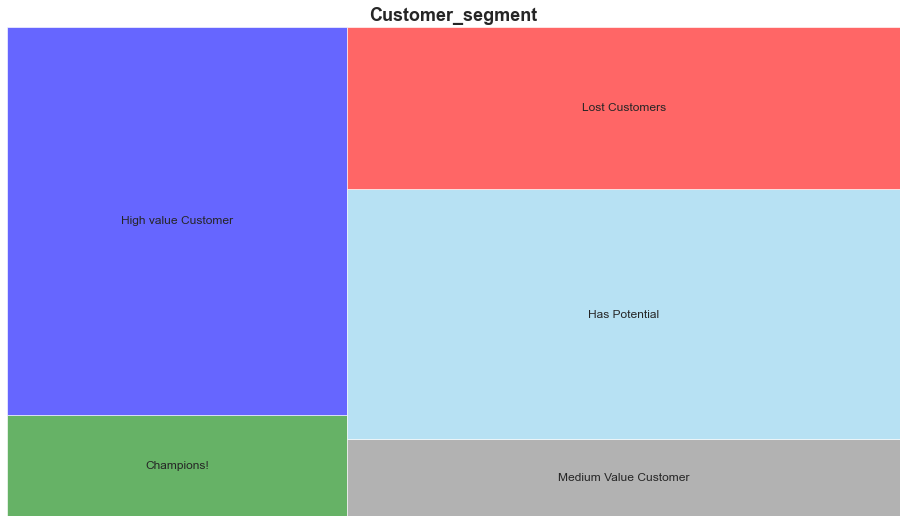

In [183]:
#Visulize class distribution

import squarify
rfm_level_agg.columns = rfm_level_agg.columns.droplevel()
rfm_level_agg.columns = ['F_rank_normMean','M_rank_normMean', 'Count']
fig = plt.gcf()
ax = fig.add_subplot()
fig.set_size_inches(16, 9)
squarify.plot(sizes=rfm_level_agg['Count'], 
              label=['Champions!',
                     'High value Customer', 
                     'Medium Value Customer', 
                     'Has Potential',
                     'Lost Customers'],
              color=["green","blue", "grey",'skyblue','red'], alpha=.6 )
plt.title("Customer_segment",fontsize=18,fontweight="bold")
plt.axis('off')
plt.show()

In [184]:
rfm_table2 = rfmSeg.reset_index()

rfm_monetary_size = rfm_table2.groupby("Customer_segment").agg({"MonetaryValue": "mean",
                                                       "user_id": "nunique"})

rfm_monetary_size.rename(columns = {"MonetaryValue": "MeanMonetary", "user_id": "CustomerCount"}, inplace = True)
rfm_monetary_size = rfm_monetary_size.sort_values("MeanMonetary", ascending = False)

In [185]:
rfm_monetary_size

,MeanMonetary,CustomerCount
Customer_segment,,
Champions!,81.988479,4384
High value Customer,40.345726,5400
Medium Value Customer,22.203328,11449
Has Potential,10.919930,16883
Lost Customers,4.709002,17718


In [231]:
rfm_table2 = rfmSeg.reset_index()

rfm_freaq_size = rfm_table2.groupby("Customer_segment").agg({"Frequency": "mean",
                                                       "user_id": "nunique"})

rfm_freaq_size.rename(columns = {"Frequency": "MeanFrequency", "user_id": "CustomerCount"}, inplace = True)
rfm_freaq_size = rfm_freaq_size.sort_values("MeanFrequency", ascending = False)

In [232]:
rfm_freaq_size

,MeanFrequency,CustomerCount
Customer_segment,,
Champions!,17.395985,4384
High value Customer,7.878148,5400
Medium Value Customer,4.105162,11449
Has Potential,1.885210,16883
Lost Customers,1.035444,17718


In [233]:
rfm_freaq_size= rfm_freaq_size.rename_axis('Customer_segment').reset_index()

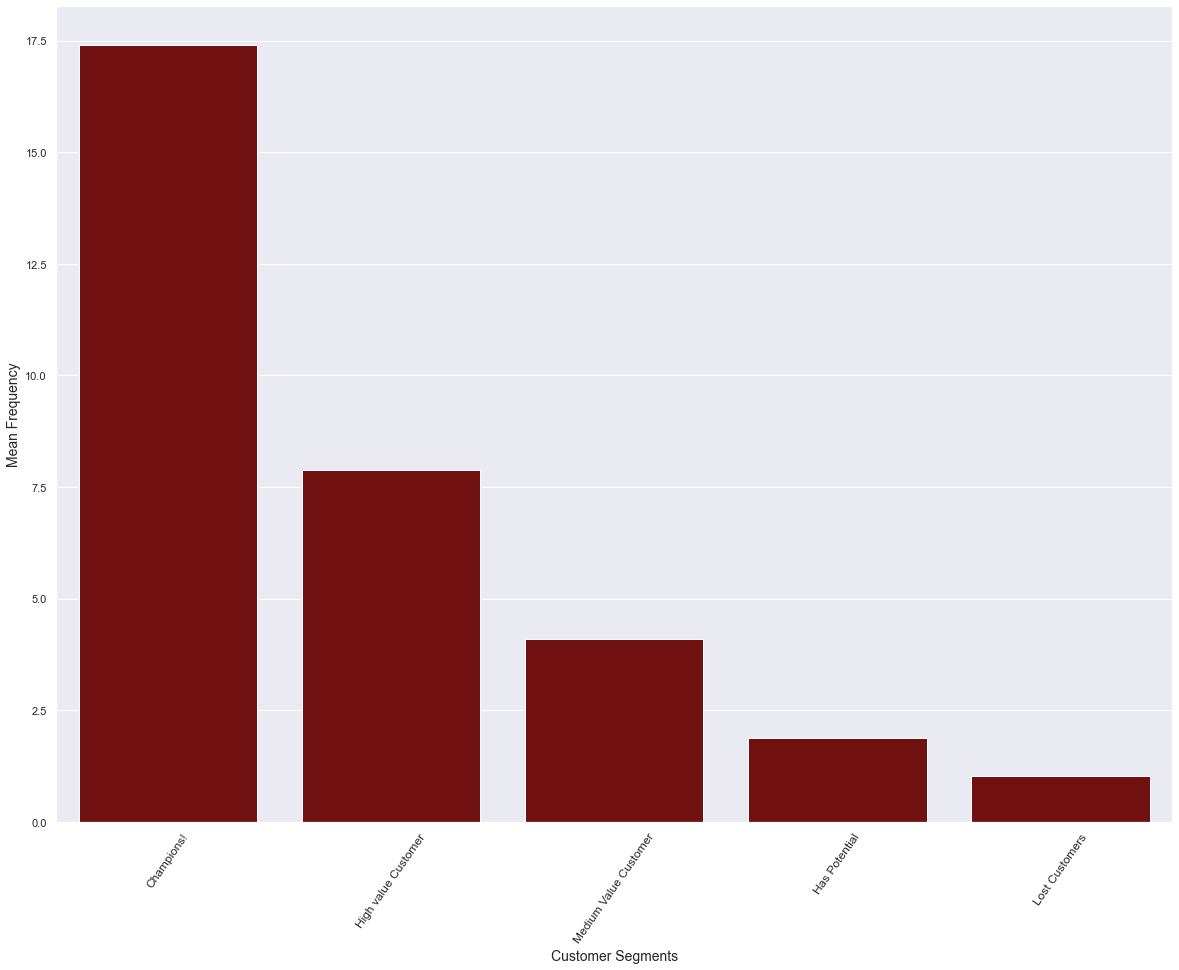

In [236]:
plt.figure(figsize=(20,15))
sns.barplot(x='Customer_segment',y='MeanFrequency',data=rfm_freaq_size,color='maroon')
plt.xticks(rotation=55,fontsize=12)
plt.xlabel('Customer Segments',fontsize=14)
plt.ylabel('Mean Frequency',fontsize=14)
plt.show()

In [212]:
rfm_monetary_size= rfm_monetary_size.reset_index()

In [213]:
rfm_monetary_size3=rfm_monetary_size[['Customer_segment','CustomerCount']]

In [214]:
rfm_monetary_size3

,Customer_segment,CustomerCount
0,Champions!,4384
1,High value Customer,5400
2,Medium Value Customer,11449
3,Has Potential,16883
4,Lost Customers,17718


In [208]:
rfm_efood_all=pd.read_csv('rfm_efood_all.csv')

In [209]:
rfm_efood_all

,Customer_segment,CustomerCount
0,Champions!,9416
1,High value Customer,12087
2,Medium Value Customer,25762
3,Has Potential,36332
4,Lost Customers,38346


In [221]:
data_count=rfm_efood_all.merge(rfm_monetary_size3, left_on='Customer_segment', right_on='Customer_segment')

In [222]:
data_count.rename(columns = {'CustomerCount_x':'CustomerCount_all', 'CustomerCount_y':'CustomerCount_Break'}, inplace = True)

In [223]:
data_count

,Customer_segment,CustomerCount_all,CustomerCount_Break
0,Champions!,9416,4384
1,High value Customer,12087,5400
2,Medium Value Customer,25762,11449
3,Has Potential,36332,16883
4,Lost Customers,38346,17718


In [224]:
data_count['perc']=(data_count['CustomerCount_Break']/data_count['CustomerCount_all'])*100

In [225]:
data_count

,Customer_segment,CustomerCount_all,CustomerCount_Break,perc
0,Champions!,9416,4384,46.559048
1,High value Customer,12087,5400,44.676098
2,Medium Value Customer,25762,11449,44.441425
3,Has Potential,36332,16883,46.468678
4,Lost Customers,38346,17718,46.205602


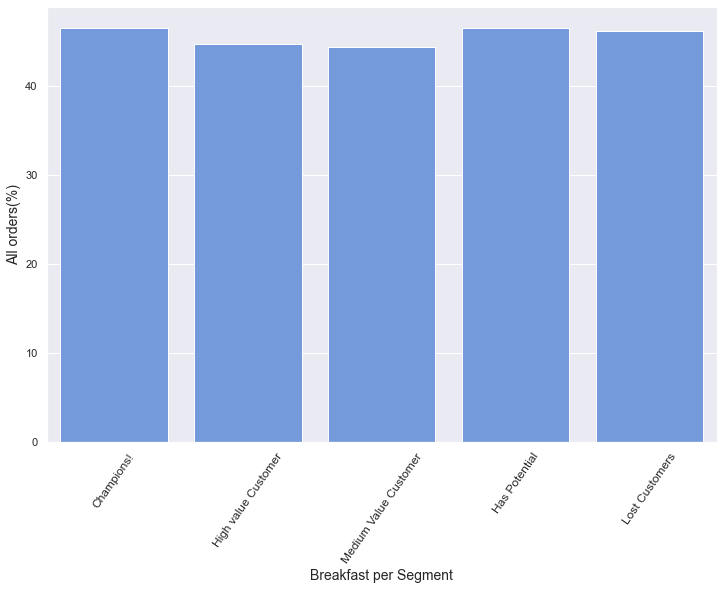

In [237]:
plt.figure(figsize=(12,8))
sns.barplot(x='Customer_segment',y='perc',data=data_count,color='cornflowerblue')
plt.xticks(rotation=55,fontsize=12)
plt.xlabel('Breakfast per Segment',fontsize=14)
plt.ylabel('All orders(%)',fontsize=14)
plt.show()

In [187]:
rfm_table2 = rfmSeg.reset_index()

rfm_monetary_size2 = rfm_table2.groupby("Customer_segment").agg({"Frequency": "mean",
                                                       "user_id": "nunique"})

rfm_monetary_size2.rename(columns = {"Frequency": "MeanFrequency", "user_id": "CustomerCount"}, inplace = True)
rfm_monetary_size2 = rfm_monetary_size2.sort_values("MeanFrequency", ascending = False)

In [188]:
rfm_monetary_size2

,MeanFrequency,CustomerCount
Customer_segment,,
Champions!,17.395985,4384
High value Customer,7.878148,5400
Medium Value Customer,4.105162,11449
Has Potential,1.885210,16883
Lost Customers,1.035444,17718


In [238]:
#how many customers in each segment and their mean monetary value visualize

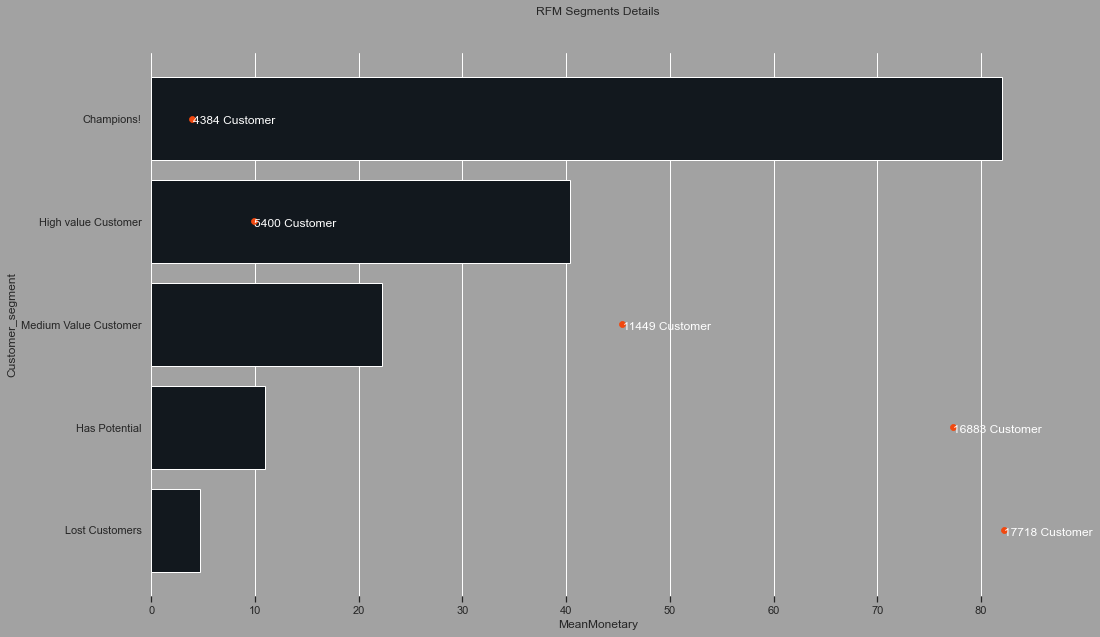

In [189]:
plt.rcParams["axes.facecolor"] = "#A2A2A2"
fig, ax = plt.subplots(figsize = (16, 10), facecolor = "#A2A2A2")

sns.barplot(x = rfm_monetary_size.MeanMonetary, y = rfm_monetary_size.index, ax = ax, color = "#101820")
ax2 = ax.twiny()
sns.lineplot(x = rfm_monetary_size.CustomerCount, y = rfm_monetary_size.index, ax = ax2, marker = "o", linewidth = 0,
             color = "#F1480F", markeredgecolor = "#F1480F")


ax2.axis("off")

for y, x in list(enumerate(rfm_monetary_size.CustomerCount)):
    ax2.text(x + 10, y + 0.05, str(x) + " Customer", color = "white", fontweight = "normal")

plt.title("RFM Segments Details")
sns.despine(left = True, right = True, bottom = True, top = True)
plt.show()

In [190]:
monetary_per_segment = (rfm_table2.groupby("Customer_segment")["MonetaryValue"].sum() /\
                        rfm_table2.groupby("Customer_segment")["MonetaryValue"].sum().sum()).sort_values(ascending = False)

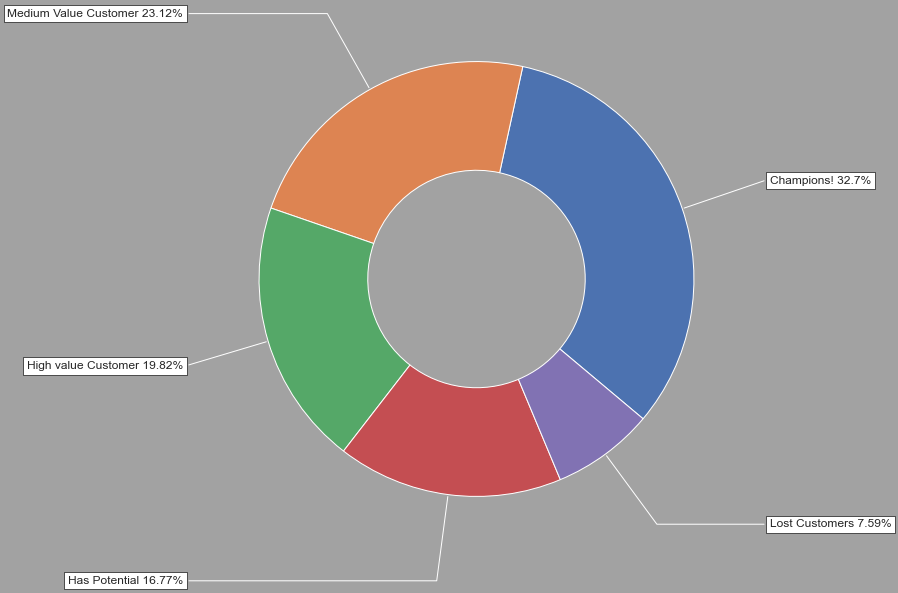

In [191]:
fig, ax = plt.subplots(figsize = (10, 10), facecolor = "#A2A2A2")

wedges, texts = ax.pie(monetary_per_segment.values, wedgeprops=dict(width=0.5), 
                       startangle=-40, normalize=False)

bbox_props = dict(boxstyle="square,pad=0.3", fc="w", ec="k", lw=0.72)
kw = dict(arrowprops=dict(arrowstyle="-"),
          bbox=bbox_props, zorder=0, va="center")

for i, p in enumerate(wedges):
    ang = (p.theta2 - p.theta1)/2. + p.theta1
    y = np.sin(np.deg2rad(ang))
    x = np.cos(np.deg2rad(ang))
    horizontalalignment = {-1: "right", 1: "left"}[int(np.sign(x))]
    connectionstyle = "angle,angleA=0,angleB={}".format(ang)
    kw["arrowprops"].update({"connectionstyle": connectionstyle})
    ax.annotate(monetary_per_segment.index[i] + " " + str(round(monetary_per_segment[i] * 100, 2)) + "%", xy=(x, y), 
                xytext=(1.35*np.sign(x), 1.4*y),horizontalalignment=horizontalalignment, **kw)
plt.show()

In [192]:
#get RFLM Level and the user id as the key to merge with data

df1 = pd.DataFrame(rfmSeg, columns=['Customer_segment']).reset_index()

In [193]:
data_break=df2_break.merge(df1, left_on='user_id', right_on='user_id')

In [194]:
data_break.head()

,user_id,city,Num_of_orders,order_id,cuisine,paid_cash,amount,order_date,month,day,hour,Customer_segment
0,110361993,Ρόδος,11,7249621603152,Breakfast,False,4.3,2022-01-08 11:17:38+00:00,1,Saturday,11,Lost Customers
1,144777339,Αίγιο,14,7214818797164,Breakfast,False,4.8,2022-01-03 09:45:07+00:00,1,Monday,9,Champions!
2,144777339,Αίγιο,14,7222040969548,Breakfast,False,3.3,2022-01-04 11:13:56+00:00,1,Tuesday,11,Champions!
3,144777339,Αίγιο,14,7228946244036,Breakfast,False,3.2,2022-01-05 12:09:20+00:00,1,Wednesday,12,Champions!
4,144777339,Αίγιο,14,7236022202912,Breakfast,True,4.6,2022-01-06 12:53:50+00:00,1,Thursday,12,Champions!


In [ ]:
#Customers level for Breakfast orders visualize

Text(0, 0.5, 'orders')

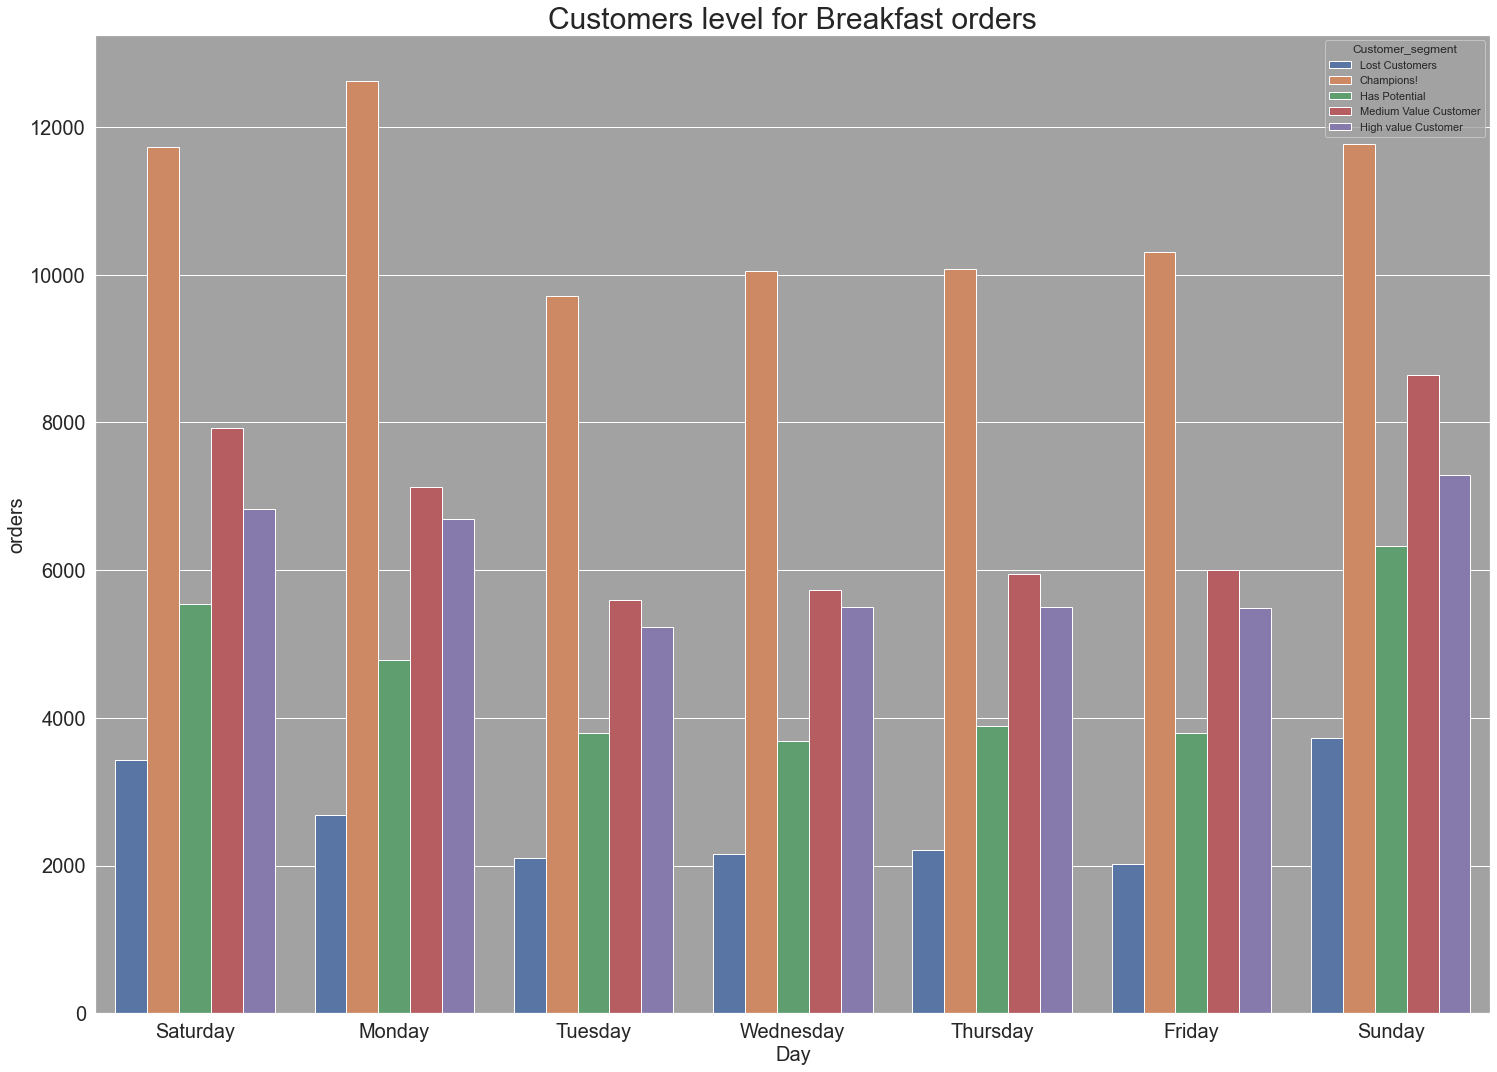

In [195]:
sns.countplot(x='day',hue='Customer_segment',data=data_break)
sns.set(rc={'figure.figsize':(25,18)})
plt.xticks(rotation=0,fontsize=20)
plt.yticks(rotation=0,fontsize=20)
plt.title("Customers level for Breakfast orders",fontsize=30)
plt.xlabel('Day', fontsize=20)
plt.ylabel('orders', fontsize=20)